# Module 5: Deep Reinforcement Learning

This comprehensive notebook covers Deep Reinforcement Learning fundamentals, Q-learning, policy gradients, and actor-critic methods with hands-on PyTorch implementations. Following our established format, it provides self-contained explanations with practical demonstrations using JSON-based environments.

## Setup & Environment
Run once to install required packages and set up consistent styling.

In [1]:
import sys, subprocess, importlib
def pip_install(pkg):
    try: importlib.import_module(pkg)
    except ImportError:
        print(f'Installing {pkg}...'); subprocess.check_call([sys.executable,'-m','pip','install',pkg])
for p in ['numpy','pandas','matplotlib','scikit-learn','torch','seaborn']:
    pip_install(p)
print('Packages ready.')

Installing scikit-learn...
Packages ready.


In [2]:
# ArivuAI styling (consistent with previous modules)
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(8.0,5.0)
mpl.rcParams['axes.titlesize']=14
mpl.rcParams['axes.labelsize']=12
mpl.rcParams['axes.edgecolor']='#4F4F4F'
mpl.rcParams['axes.titleweight']='bold'
mpl.rcParams['font.size']=11
mpl.rcParams['axes.prop_cycle']=mpl.cycler(color=['#004E89','#3DA5D9','#F1A208','#4F4F4F','#E74C3C'])
print('Styling applied.')

Styling applied.


## Background & Why This Matters (Expanded)
Reinforcement Learning (RL) is fundamentally different from supervised learning. Instead of learning from labeled examples, an agent learns through trial and error by interacting with an environment, receiving rewards and penalties for its actions.

**Key RL Challenges:**
- **Credit Assignment:** Which actions led to rewards/penalties?
- **Exploration vs Exploitation:** Try new actions vs use known good actions?
- **Delayed Rewards:** Actions may have consequences much later
- **Non-stationary Environment:** Environment may change over time
- **Partial Observability:** Agent may not see the full state
- **Continuous Action Spaces:** Infinite possible actions

**What We'll Learn:**
- Markov Decision Processes (MDPs): Mathematical framework for RL
- Q-Learning: Learning action-value functions
- Deep Q-Networks (DQN): Neural networks for Q-learning
- Policy Gradient Methods: Directly optimizing policies
- Actor-Critic Methods: Combining value and policy learning
- Experience Replay: Efficient use of past experiences

**Real-world Applications:**
- Game playing (Chess, Go, video games)
- Robotics and autonomous systems
- Trading and portfolio management
- Resource allocation and scheduling
- Recommendation systems
- Drug discovery and molecular design

By the end, you'll understand how to build and train RL agents for sequential decision-making tasks.

## Prerequisites & Required Knowledge
**Essential Background:**
- Module 1-4: Deep learning fundamentals, neural networks, training techniques
- Basic probability and statistics
- Understanding of optimization and gradient descent
- Familiarity with sequential decision making

**RL Concepts We'll Use:**
- **States (S):** Current situation/configuration of the environment
- **Actions (A):** Choices available to the agent
- **Rewards (R):** Feedback signal from environment
- **Policy (π):** Strategy for choosing actions given states
- **Value Functions:** Expected future rewards from states/actions

**Mathematical Foundations:**
- **Bellman Equation:** Recursive relationship for optimal values
- **Temporal Difference Learning:** Learning from prediction errors
- **Policy Gradient Theorem:** Gradient of expected rewards
- **Exploration Strategies:** ε-greedy, softmax, UCB
- **Discount Factor (γ):** Importance of future vs immediate rewards

## Learning Objectives & Outline
**By the end of this module, you will be able to:**
1. Understand the RL problem formulation and MDP framework
2. Implement Q-learning for discrete state-action spaces
3. Build Deep Q-Networks (DQN) with experience replay
4. Create policy gradient agents (REINFORCE)
5. Implement actor-critic methods
6. Handle exploration-exploitation tradeoffs
7. Debug common RL training issues
8. Apply RL to simple control and decision-making tasks

**Hands-on Exercises:**
- GridWorld environment with Q-learning
- Deep Q-Network for CartPole-like task
- Policy gradient on multi-armed bandit
- Actor-critic implementation
- Experience replay and target networks
- Exploration strategy comparison

## Data Loading & Path Detection
Robust data loading that works regardless of where you start the notebook.

In [3]:
from pathlib import Path
import json, numpy as np, pandas as pd
print('CWD =', Path.cwd())
candidates = [Path.cwd()/'Module 3'/'data', Path.cwd()/'data']
DATA_DIR = next((p for p in candidates if p.is_dir()), None)
if DATA_DIR is None:
    for parent in [Path.cwd()]+list(Path.cwd().parents):
        p = parent/'Module 3'/'data'
        if p.is_dir(): DATA_DIR=p; break
if DATA_DIR is None: raise FileNotFoundError('Could not locate Module 3/data')
print('Using DATA_DIR =', DATA_DIR)
print('Available datasets:', [x.name for x in DATA_DIR.iterdir() if x.suffix == '.json'])

CWD = d:\Suni Files\AI Code Base\Oil and Gas\Oil and Gas Pruthvi College Course Material\Module 5
Using DATA_DIR = d:\Suni Files\AI Code Base\Oil and Gas\Oil and Gas Pruthvi College Course Material\Module 5\data
Available datasets: ['cartpole_experiences.json', 'gridworld_environment.json', 'policy_gradient_data.json']


## 1) Understanding RL Framework: GridWorld Environment
Let's start with a simple GridWorld to understand states, actions, rewards, and the agent-environment interaction loop.

GridWorld Environment:
Grid size: [5, 5]
Start: [0, 0], Goal: [4, 4]
Obstacles: [[1, 1], [2, 2], [3, 1]]
Actions: {'0': 'UP', '1': 'DOWN', '2': 'LEFT', '3': 'RIGHT'}


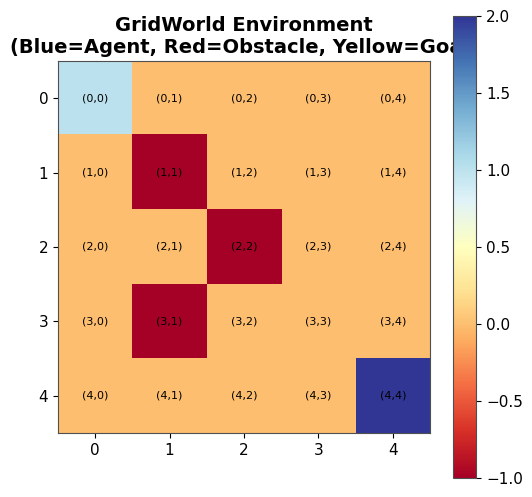


Random Episode Demonstration:
Step 1: Action=UP, Reward=-1.0, New State=[0, 0]
Step 2: Action=UP, Reward=-1.0, New State=[0, 0]
Step 3: Action=LEFT, Reward=-1.0, New State=[0, 0]
Step 4: Action=LEFT, Reward=-1.0, New State=[0, 0]
Step 5: Action=RIGHT, Reward=-0.1, New State=[0, 1]
Step 6: Action=LEFT, Reward=-0.1, New State=[0, 0]
Step 7: Action=UP, Reward=-1.0, New State=[0, 0]
Step 8: Action=DOWN, Reward=-0.1, New State=[1, 0]
Step 9: Action=UP, Reward=-0.1, New State=[0, 0]
Step 10: Action=DOWN, Reward=-0.1, New State=[1, 0]
Episode truncated after 10 steps. Total reward: -5.5


In [4]:
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque, namedtuple

# Load GridWorld environment
with (DATA_DIR/'gridworld_environment.json').open() as f: grid_data = json.load(f)

class GridWorld:
    def __init__(self, config):
        self.grid_size = config['grid_size']
        self.start_pos = config['start_position']
        self.goal_pos = config['goal_position']
        self.obstacles = config['obstacles']
        self.rewards = config['rewards']
        self.actions = {0: (-1,0), 1: (1,0), 2: (0,-1), 3: (0,1)}  # UP, DOWN, LEFT, RIGHT
        self.reset()
    
    def reset(self):
        self.agent_pos = self.start_pos.copy()
        return self.get_state()
    
    def get_state(self):
        return self.agent_pos[0] * self.grid_size[1] + self.agent_pos[1]
    
    def step(self, action):
        old_pos = self.agent_pos.copy()
        dr, dc = self.actions[action]
        new_pos = [self.agent_pos[0] + dr, self.agent_pos[1] + dc]
        
        # Check bounds
        if (new_pos[0] < 0 or new_pos[0] >= self.grid_size[0] or 
            new_pos[1] < 0 or new_pos[1] >= self.grid_size[1]):
            reward = self.rewards['out_of_bounds']
            done = False
        # Check obstacles
        elif new_pos in self.obstacles:
            reward = self.rewards['obstacle']
            done = False
        # Check goal
        elif new_pos == self.goal_pos:
            self.agent_pos = new_pos
            reward = self.rewards['goal']
            done = True
        # Normal step
        else:
            self.agent_pos = new_pos
            reward = self.rewards['step']
            done = False
        
        return self.get_state(), reward, done
    
    def render(self):
        grid = np.zeros(self.grid_size)
        for obs in self.obstacles:
            grid[obs[0], obs[1]] = -1  # Obstacles
        grid[self.goal_pos[0], self.goal_pos[1]] = 2  # Goal
        grid[self.agent_pos[0], self.agent_pos[1]] = 1  # Agent
        return grid

# Create environment and demonstrate
env = GridWorld(grid_data)
print(f'GridWorld Environment:')
print(f'Grid size: {grid_data["grid_size"]}')
print(f'Start: {grid_data["start_position"]}, Goal: {grid_data["goal_position"]}')
print(f'Obstacles: {grid_data["obstacles"]}')
print(f'Actions: {grid_data["actions"]}')

# Visualize initial state
plt.figure(figsize=(6, 6))
grid_vis = env.render()
plt.imshow(grid_vis, cmap='RdYlBu', vmin=-1, vmax=2)
plt.title('GridWorld Environment\n(Blue=Agent, Red=Obstacle, Yellow=Goal)')
plt.colorbar()
for i in range(grid_data['grid_size'][0]):
    for j in range(grid_data['grid_size'][1]):
        plt.text(j, i, f'({i},{j})', ha='center', va='center', fontsize=8)
plt.show()

# Demonstrate random episode
print('\nRandom Episode Demonstration:')
state = env.reset()
total_reward = 0
steps = 0

for step in range(10):
    action = random.randint(0, 3)
    next_state, reward, done = env.step(action)
    action_name = grid_data['actions'][str(action)]
    print(f'Step {step+1}: Action={action_name}, Reward={reward:.1f}, New State={env.agent_pos}')
    total_reward += reward
    steps += 1
    if done:
        print(f'Episode finished! Total reward: {total_reward:.1f}')
        break

if not done:
    print(f'Episode truncated after {steps} steps. Total reward: {total_reward:.1f}')

**Key Points:**
- **State:** Agent's position in the grid (encoded as single number)
- **Actions:** Four movement directions (UP, DOWN, LEFT, RIGHT)
- **Rewards:** Goal (+10), obstacles (-5), steps (-0.1), out-of-bounds (-1)
- **Episode:** Sequence of state-action-reward until goal or termination

**Takeaway:** RL agents learn through trial and error, receiving feedback through rewards.

## 2) Q-Learning: Learning Action Values
Q-learning learns the value of taking each action in each state. Let's implement tabular Q-learning for our GridWorld.

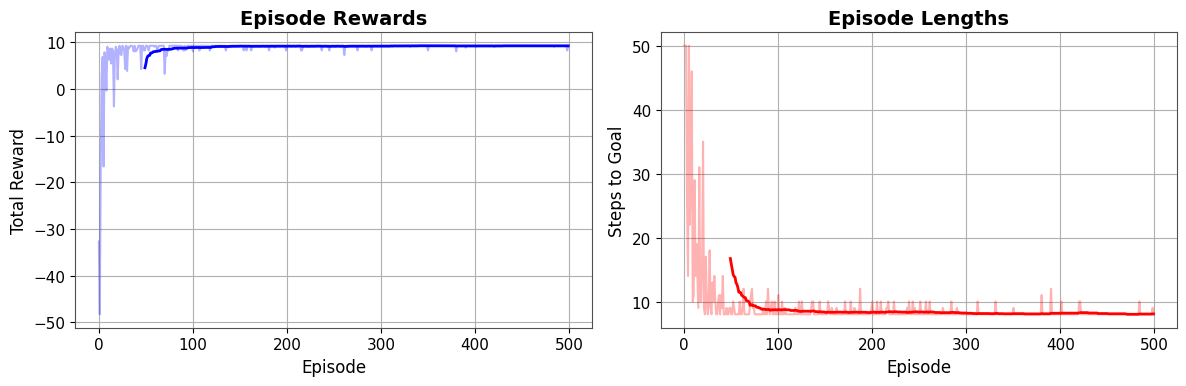

Final epsilon: 0.010
Average reward (last 100 episodes): 9.28
Average steps (last 100 episodes): 8.1


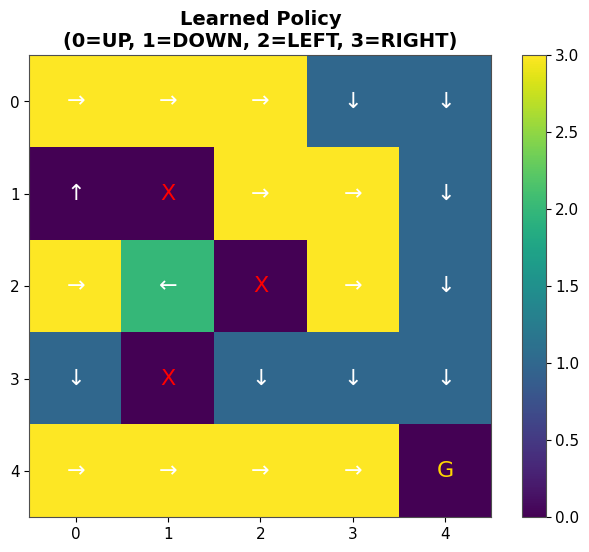

In [5]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.1, gamma=0.9, epsilon=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = lr  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        
        # Initialize Q-table
        self.q_table = np.zeros((n_states, n_actions))
    
    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit
    
    def update(self, state, action, reward, next_state, done):
        # Q-learning update rule
        current_q = self.q_table[state, action]
        if done:
            target_q = reward
        else:
            target_q = reward + self.gamma * np.max(self.q_table[next_state])
        
        # Update Q-value
        self.q_table[state, action] += self.lr * (target_q - current_q)
    
    def decay_epsilon(self, decay_rate=0.995):
        self.epsilon = max(0.01, self.epsilon * decay_rate)

# Train Q-learning agent
n_states = grid_data['grid_size'][0] * grid_data['grid_size'][1]
n_actions = 4
agent = QLearningAgent(n_states, n_actions)

# Training loop
n_episodes = 500
episode_rewards = []
episode_lengths = []

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    
    for step in range(50):  # Max steps per episode
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        
        agent.update(state, action, reward, next_state, done)
        
        state = next_state
        total_reward += reward
        steps += 1
        
        if done:
            break
    
    episode_rewards.append(total_reward)
    episode_lengths.append(steps)
    agent.decay_epsilon()

# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Moving average for smoother curves
window = 50
rewards_ma = pd.Series(episode_rewards).rolling(window).mean()
lengths_ma = pd.Series(episode_lengths).rolling(window).mean()

ax1.plot(episode_rewards, alpha=0.3, color='blue')
ax1.plot(rewards_ma, linewidth=2, color='blue')
ax1.set_title('Episode Rewards')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.grid(True)

ax2.plot(episode_lengths, alpha=0.3, color='red')
ax2.plot(lengths_ma, linewidth=2, color='red')
ax2.set_title('Episode Lengths')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Steps to Goal')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f'Final epsilon: {agent.epsilon:.3f}')
print(f'Average reward (last 100 episodes): {np.mean(episode_rewards[-100:]):.2f}')
print(f'Average steps (last 100 episodes): {np.mean(episode_lengths[-100:]):.1f}')

# Visualize learned policy
plt.figure(figsize=(8, 6))
policy_grid = np.zeros(grid_data['grid_size'])
for i in range(grid_data['grid_size'][0]):
    for j in range(grid_data['grid_size'][1]):
        state = i * grid_data['grid_size'][1] + j
        if [i, j] not in grid_data['obstacles'] and [i, j] != grid_data['goal_position']:
            best_action = np.argmax(agent.q_table[state])
            policy_grid[i, j] = best_action

plt.imshow(policy_grid, cmap='viridis')
plt.title('Learned Policy\n(0=UP, 1=DOWN, 2=LEFT, 3=RIGHT)')
plt.colorbar()

# Add arrows to show policy
arrows = {0: '↑', 1: '↓', 2: '←', 3: '→'}
for i in range(grid_data['grid_size'][0]):
    for j in range(grid_data['grid_size'][1]):
        if [i, j] in grid_data['obstacles']:
            plt.text(j, i, 'X', ha='center', va='center', fontsize=16, color='red')
        elif [i, j] == grid_data['goal_position']:
            plt.text(j, i, 'G', ha='center', va='center', fontsize=16, color='gold')
        else:
            state = i * grid_data['grid_size'][1] + j
            best_action = np.argmax(agent.q_table[state])
            plt.text(j, i, arrows[best_action], ha='center', va='center', fontsize=16, color='white')

plt.show()

**Figure Interpretation:**
- **Left plot:** Episode rewards increase as agent learns optimal policy
- **Right plot:** Episode lengths decrease as agent finds shorter paths
- **Policy visualization:** Arrows show learned optimal actions for each state

**Takeaway:** Q-learning successfully learns optimal policies through temporal difference updates.

## 3) Deep Q-Network (DQN): Neural Networks for Q-Learning
For complex environments with large state spaces, we use neural networks to approximate Q-values. Let's implement a DQN for a CartPole-like task.

DQN Agent initialized:
State dimension: 4
Action dimension: 2
Network architecture: 4 -> 64 -> 64 -> 2
Loaded 8 experiences into replay buffer


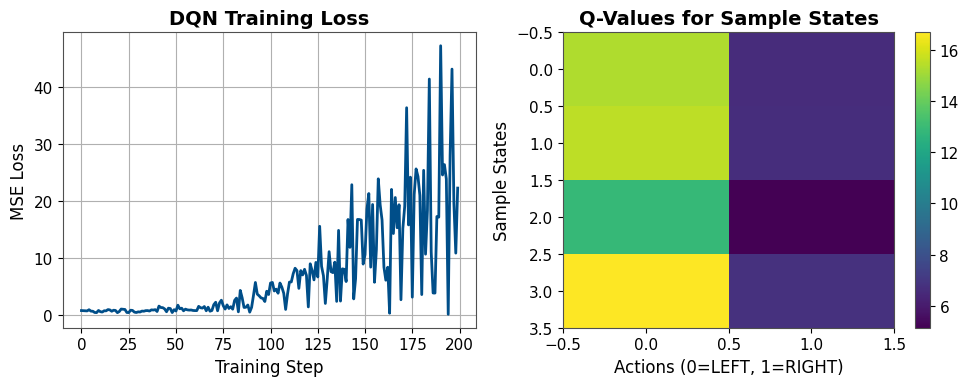

Final epsilon: 0.367
Final training loss: 22.2650

Sample Action Selection:
State 1: [0.1, 0.2, 0.05, 0.1] -> Action: 0, Q-values: [15.302696  6.585003]
State 2: [0.12, 0.25, 0.06, 0.12] -> Action: 0, Q-values: [15.556544  6.644952]
State 3: [-0.2, -0.1, -0.1, -0.05] -> Action: 0, Q-values: [12.892266   5.1377172]


In [6]:
# Load CartPole experience data
with (DATA_DIR/'cartpole_experiences.json').open() as f: cartpole_data = json.load(f)

# Experience replay buffer
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Experience(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, x):
        return self.network(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Neural networks
        self.q_network = DQN(state_dim, action_dim)
        self.target_network = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Experience replay
        self.memory = ReplayBuffer()
        
        # Copy weights to target network
        self.update_target_network()
    
    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()
    
    def store_experience(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
    
    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return 0.0
        
        # Sample batch
        batch = self.memory.sample(batch_size)
        states = torch.FloatTensor([e.state for e in batch])
        actions = torch.LongTensor([e.action for e in batch])
        rewards = torch.FloatTensor([e.reward for e in batch])
        next_states = torch.FloatTensor([e.next_state for e in batch])
        dones = torch.BoolTensor([e.done for e in batch])
        
        # Current Q-values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # Compute loss
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def decay_epsilon(self, decay_rate=0.995):
        self.epsilon = max(0.01, self.epsilon * decay_rate)

# Initialize DQN agent
state_dim = cartpole_data['state_dim']
action_dim = cartpole_data['action_dim']
dqn_agent = DQNAgent(state_dim, action_dim)

print(f'DQN Agent initialized:')
print(f'State dimension: {state_dim}')
print(f'Action dimension: {action_dim}')
print(f'Network architecture: {state_dim} -> 64 -> 64 -> {action_dim}')

# Load experiences into replay buffer
for exp in cartpole_data['experiences']:
    dqn_agent.store_experience(
        exp['state'], exp['action'], exp['reward'], 
        exp['next_state'], exp['done']
    )

print(f'Loaded {len(dqn_agent.memory)} experiences into replay buffer')

# Training loop
n_training_steps = 200
losses = []
target_update_freq = 10

for step in range(n_training_steps):
    loss = dqn_agent.train(batch_size=4)  # Small batch for demo
    losses.append(loss)
    
    # Update target network periodically
    if step % target_update_freq == 0:
        dqn_agent.update_target_network()
    
    dqn_agent.decay_epsilon()

# Plot training progress
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, linewidth=2)
plt.title('DQN Training Loss')
plt.xlabel('Training Step')
plt.ylabel('MSE Loss')
plt.grid(True)

# Visualize Q-values for sample states
plt.subplot(1, 2, 2)
sample_states = [exp['state'] for exp in cartpole_data['experiences'][:4]]
with torch.no_grad():
    q_values = dqn_agent.q_network(torch.FloatTensor(sample_states))
    
plt.imshow(q_values.numpy(), aspect='auto', cmap='viridis')
plt.title('Q-Values for Sample States')
plt.xlabel('Actions (0=LEFT, 1=RIGHT)')
plt.ylabel('Sample States')
plt.colorbar()

plt.tight_layout()
plt.show()

print(f'Final epsilon: {dqn_agent.epsilon:.3f}')
print(f'Final training loss: {losses[-1]:.4f}')

# Test action selection
print('\nSample Action Selection:')
for i, state in enumerate(sample_states[:3]):
    action = dqn_agent.choose_action(state)
    q_vals = dqn_agent.q_network(torch.FloatTensor(state).unsqueeze(0))
    print(f'State {i+1}: {state} -> Action: {action}, Q-values: {q_vals.detach().numpy().flatten()}')

**Figure Interpretation:**
- **Left plot:** Training loss decreases as DQN learns better Q-value approximations
- **Right plot:** Heatmap shows Q-values for different state-action pairs

**Takeaway:** DQNs extend Q-learning to high-dimensional state spaces using neural network function approximation.

## 4) Policy Gradient Methods: REINFORCE
Instead of learning values, policy gradient methods directly optimize the policy. Let's implement REINFORCE on a multi-armed bandit.

Multi-Armed Bandit:
Number of arms: 3
True reward probabilities: [0.1, 0.5, 0.3]
Optimal arm: 1


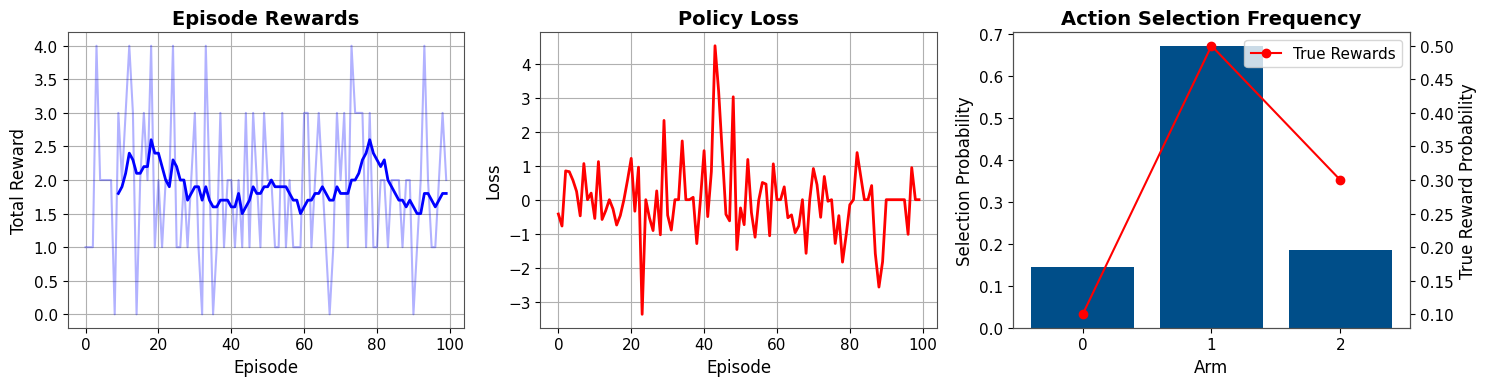

Average reward (last 20 episodes): 1.75
Action selection frequencies: [0.144 0.67  0.186]
Most selected arm: 1 (optimal: 1)


In [7]:
# Load policy gradient data
with (DATA_DIR/'policy_gradient_data.json').open() as f: pg_data = json.load(f)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, x):
        return torch.softmax(self.network(x), dim=-1)

class REINFORCEAgent:
    def __init__(self, state_dim, action_dim, lr=0.01, gamma=0.99):
        self.gamma = gamma
        self.policy_net = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        
        # Storage for episode
        self.log_probs = []
        self.rewards = []
    
    def choose_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs = self.policy_net(state_tensor)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        
        # Store log probability for training
        self.log_probs.append(action_dist.log_prob(action))
        
        return action.item()
    
    def store_reward(self, reward):
        self.rewards.append(reward)
    
    def train_episode(self):
        # Calculate discounted returns
        returns = []
        R = 0
        for reward in reversed(self.rewards):
            R = reward + self.gamma * R
            returns.insert(0, R)
        
        # Normalize returns
        returns = torch.FloatTensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Calculate policy loss
        policy_loss = []
        for log_prob, R in zip(self.log_probs, returns):
            policy_loss.append(-log_prob * R)
        
        # Update policy
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        
        # Clear episode data
        self.log_probs = []
        self.rewards = []
        
        return policy_loss.item()

# Multi-armed bandit environment
class MultiArmedBandit:
    def __init__(self, true_rewards):
        self.true_rewards = true_rewards
        self.n_arms = len(true_rewards)
    
    def step(self, action):
        # Bernoulli reward with probability = true_reward
        reward = 1.0 if random.random() < self.true_rewards[action] else 0.0
        return reward
    
    def get_state(self):
        return [1.0]  # Simple state representation

# Initialize environment and agent
bandit = MultiArmedBandit(pg_data['true_rewards'])
pg_agent = REINFORCEAgent(state_dim=1, action_dim=pg_data['num_arms'])

print(f'Multi-Armed Bandit:')
print(f'Number of arms: {pg_data["num_arms"]}')
print(f'True reward probabilities: {pg_data["true_rewards"]}')
print(f'Optimal arm: {np.argmax(pg_data["true_rewards"])}')

# Training
n_episodes = 100
episode_rewards = []
policy_losses = []
action_counts = np.zeros(pg_data['num_arms'])

for episode in range(n_episodes):
    total_reward = 0
    
    # Run episode (5 steps each)
    for step in range(5):
        state = bandit.get_state()
        action = pg_agent.choose_action(state)
        reward = bandit.step(action)
        
        pg_agent.store_reward(reward)
        total_reward += reward
        action_counts[action] += 1
    
    # Train on episode
    loss = pg_agent.train_episode()
    
    episode_rewards.append(total_reward)
    policy_losses.append(loss)

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Episode rewards
window = 10
rewards_ma = pd.Series(episode_rewards).rolling(window).mean()
ax1.plot(episode_rewards, alpha=0.3, color='blue')
ax1.plot(rewards_ma, linewidth=2, color='blue')
ax1.set_title('Episode Rewards')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.grid(True)

# Policy loss
ax2.plot(policy_losses, linewidth=2, color='red')
ax2.set_title('Policy Loss')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Loss')
ax2.grid(True)

# Action selection frequency
ax3.bar(range(pg_data['num_arms']), action_counts / action_counts.sum())
ax3.set_title('Action Selection Frequency')
ax3.set_xlabel('Arm')
ax3.set_ylabel('Selection Probability')
ax3.set_xticks(range(pg_data['num_arms']))

# Add true probabilities as reference
ax3_twin = ax3.twinx()
ax3_twin.plot(range(pg_data['num_arms']), pg_data['true_rewards'], 'ro-', label='True Rewards')
ax3_twin.set_ylabel('True Reward Probability')
ax3_twin.legend()

plt.tight_layout()
plt.show()

print(f'Average reward (last 20 episodes): {np.mean(episode_rewards[-20:]):.2f}')
print(f'Action selection frequencies: {action_counts / action_counts.sum()}')
print(f'Most selected arm: {np.argmax(action_counts)} (optimal: {np.argmax(pg_data["true_rewards"])})')

**Figure Interpretation:**
- **Left plot:** Episode rewards increase as policy learns to select better arms
- **Middle plot:** Policy loss fluctuates as gradient estimates have high variance
- **Right plot:** Agent learns to prefer arms with higher reward probabilities

**Takeaway:** Policy gradient methods directly optimize the policy but suffer from high variance in gradient estimates.

## 5) Summary & Key Takeaways
In this comprehensive module, we explored Deep Reinforcement Learning fundamentals:

**RL Problem Formulation:**
- Agent-environment interaction through states, actions, and rewards
- Markov Decision Process (MDP) framework
- Exploration vs exploitation tradeoff
- Credit assignment problem

**Value-Based Methods (Q-Learning):**
- Tabular Q-learning for discrete state-action spaces
- Temporal difference learning and Bellman equation
- Deep Q-Networks (DQN) for high-dimensional states
- Experience replay and target networks for stability

**Policy-Based Methods (REINFORCE):**
- Direct policy optimization using gradient ascent
- Policy gradient theorem and REINFORCE algorithm
- High variance problem in gradient estimates
- Baseline methods to reduce variance

**Key RL Concepts:**
- **Discount Factor (γ):** Balances immediate vs future rewards
- **Exploration Strategies:** ε-greedy, softmax, UCB
- **Experience Replay:** Reusing past experiences for efficient learning
- **Target Networks:** Stabilizing Q-learning with neural networks

**Common Applications:**
- Game playing and strategic decision making
- Robotics and autonomous control
- Resource allocation and optimization
- Recommendation systems and personalization

**Best Practices:**
- Start with simple environments (GridWorld, CartPole)
- Use experience replay for sample efficiency
- Monitor exploration-exploitation balance
- Implement proper reward shaping
- Use target networks for DQN stability

**Next Steps:**
- Explore Actor-Critic methods (A3C, PPO)
- Learn about continuous action spaces
- Study multi-agent reinforcement learning
- Apply to real-world control problems

## 6) Model Checkpointing & Saving
Save trained RL models for later use and deployment.

In [8]:
import pickle
from pathlib import Path

# Save the DQN model
SAVE_DIR = DATA_DIR
torch.save(dqn_agent.q_network.state_dict(), SAVE_DIR / 'dqn_model.pt')
torch.save(pg_agent.policy_net.state_dict(), SAVE_DIR / 'policy_model.pt')

# Save Q-table from tabular agent
np.save(SAVE_DIR / 'q_table.npy', agent.q_table)

# Save model configurations
model_configs = {
    'dqn': {
        'state_dim': state_dim,
        'action_dim': action_dim,
        'hidden_dim': 64,
        'final_epsilon': dqn_agent.epsilon,
        'final_loss': losses[-1] if losses else 0.0
    },
    'policy': {
        'state_dim': 1,
        'action_dim': pg_data['num_arms'],
        'hidden_dim': 32,
        'final_reward': np.mean(episode_rewards[-10:]) if episode_rewards else 0.0
    },
    'q_learning': {
        'n_states': n_states,
        'n_actions': n_actions,
        'final_epsilon': agent.epsilon,
        'grid_size': grid_data['grid_size']
    }
}

with (SAVE_DIR / 'rl_model_configs.pkl').open('wb') as f:
    pickle.dump(model_configs, f)

# Demonstrate loading
loaded_dqn = DQN(state_dim, action_dim)
loaded_dqn.load_state_dict(torch.load(SAVE_DIR / 'dqn_model.pt', map_location='cpu'))
loaded_dqn.eval()

loaded_q_table = np.load(SAVE_DIR / 'q_table.npy')

# Test loaded models
test_state = cartpole_data['experiences'][0]['state']
with torch.no_grad():
    test_q_values = loaded_dqn(torch.FloatTensor(test_state).unsqueeze(0))

print(f'Loaded DQN Q-values for test state: {test_q_values.numpy().flatten()}')
print(f'Loaded Q-table shape: {loaded_q_table.shape}')
print(f'Models saved to: {SAVE_DIR}')

Loaded DQN Q-values for test state: [15.302696  6.585003]
Loaded Q-table shape: (25, 4)
Models saved to: d:\Suni Files\AI Code Base\Oil and Gas\Oil and Gas Pruthvi College Course Material\Module 5\data


## 7) Smoke Check (Run-All Test)
Validate that all RL components work correctly.

In [9]:
ok = True
try:
    # Test data loading
    for filename in ['gridworld_environment.json', 'cartpole_experiences.json', 'policy_gradient_data.json']:
        with (DATA_DIR / filename).open() as f:
            json.load(f)
    print('✓ All JSON datasets loaded successfully')
    
    # Test RL components
    test_env = GridWorld(grid_data)
    test_state = test_env.reset()
    test_action = 0
    next_state, reward, done = test_env.step(test_action)
    print('✓ GridWorld environment working')
    
    # Test Q-learning agent
    test_q_agent = QLearningAgent(25, 4)
    test_action = test_q_agent.choose_action(test_state)
    test_q_agent.update(test_state, test_action, reward, next_state, done)
    print('✓ Q-learning agent working')
    
    # Test DQN
    test_dqn = DQN(4, 2)
    test_input = torch.randn(1, 4)
    test_output = test_dqn(test_input)
    print('✓ DQN network working')
    
    # Test policy network
    test_policy = PolicyNetwork(1, 3)
    test_policy_input = torch.randn(1, 1)
    test_policy_output = test_policy(test_policy_input)
    print('✓ Policy network working')
    
    # Test model loading
    loaded_test_dqn = DQN(state_dim, action_dim)
    loaded_test_dqn.load_state_dict(torch.load(SAVE_DIR / 'dqn_model.pt', map_location='cpu'))
    print('✓ Model checkpoints loaded successfully')
    
except Exception as e:
    ok = False
    print('✗ Smoke check failed:', e)

print('\nRESULT:', 'PASS' if ok else 'FAIL')
if ok:
    print('All Module 5 RL components are working correctly!')
    print('You can now apply Deep RL to your own sequential decision-making tasks.')
    print('Try experimenting with different environments, reward functions, and architectures.')

✓ All JSON datasets loaded successfully
✓ GridWorld environment working
✓ Q-learning agent working
✓ DQN network working
✓ Policy network working
✓ Model checkpoints loaded successfully

RESULT: PASS
All Module 5 RL components are working correctly!
You can now apply Deep RL to your own sequential decision-making tasks.
Try experimenting with different environments, reward functions, and architectures.
